
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [1]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [4]:
article = ""

topic = HumanMessage(
    content="帮我写一个基于langchain加载ollama大模型的python语句。"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

下面是一个例子，展示了如何在Python中使用LangChain库加载Ollama大模型：

```python
import langchain
 import LLMModel, PromptTemplate

模型。我们将使用Hugging Face Transformers中的Ollama。
 "mrm8488/Ollama"
据你的机器配置选择合适的设备（GPU/TPU等）

# 加载大模型
llm_model = LLMModel(
,   model_name
    device=device,
)

我们创建更灵活的提示模板。板。PromptTemplate可以帮助
变的用户输入。以定义一个可
prompt_template = PromptTemplate(
"], input_variables=["user_input
    template="请对{user_input}进行解释",
)

一个LLM Chain，用于执行任务
, prompt_template)Chain(llm_model

例输入设为“Hello World！”
Hello World!")chain.run(user_input="

print(task_result)
```

首先载入了一个大模型，然后定义了一个PromptTemplate，这是LangChain中的一个强大的提示模板构建块。最后，我们将该LLM Chain与一个输入值一起使用来产生输出。

的是：你需要确保你的设备（GPU/TPU等）上有足够的可用资源来支持大模型的使用。同时，也要确保你已经正确安装了所需的库，包括LangChain和相关的Transformer库。你可以通过在命令行中运行pip install langchain transformers来进行此操作。

In [5]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

下面是一个例子，展示了如何在Python中使用LangChain库加载Ollama大模型：

```python
import langchain
from langchain import LLMModel, PromptTemplate

# 首先，我们需要定义我们的LLM模型。我们将使用Hugging Face Transformers中的Ollama。
model_name = "mrm8488/Ollama"
device = "cuda"  # 根据你的机器配置选择合适的设备（GPU/TPU等）

# 加载大模型
llm_model = LLMModel(
    model_name,
    device=device,
)

#定义我们的prompt模板。PromptTemplate可以帮助我们创建更灵活的提示模板。
#例如，我们可以定义一个可变的用户输入。
prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="请对{user_input}进行解释",
)

# 创建一个LLM Chain，用于执行任务
chain = langchain.Chain(llm_model, prompt_template)

# 使用这个链条完成任务。这里我们将示例输入设为“Hello World！”
task_result = chain.run(user_input="Hello World!")

print(task_result)
```

在上面的示例中，我们首先载入了一个大模型，然后定义了一个PromptTemplate，这是LangChain中的一个强大的提示模板构建块。最后，我们将该LLM Chain与一个输入值一起使用来产生输出。

然而，需要注意的是：你需要确保你的设备（GPU/TPU等）上有足够的可用资源来支持大模型的使用。同时，也要确保你已经正确安装了所需的库，包括LangChain和相关的Transformer库。你可以通过在命令行中运行pip install langchain transformers来进行此操作。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [7]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

基于你的要求，我为你提供一个基于langchain加载ollama大模型的python语句示例：

```python
import langchain
Templategchain import LLMModel, Prompt
import torch

M模型。我们将使用Hugging Face Transformers中的Ollama。
"odel_name = "mrm8488/Ollama
() else "cpu")  # 根据你的机器配置选择合适的设备（GPU/TPU等）is_available

 加载大模型
llm_model = LLMModel(
    model_name,
    device=device,
)

prompt模板。PromptTemplate可以帮助我们创建更灵活的提示模板。
变的用户输入。可以定义一个可
prompt_template = PromptTemplate(
_variables=["user_input"],
}进行解释",plate="请对{user_input
)

用于执行任务LLM Chain，
 prompt_template).Chain(llm_model,

将示例输入设为“Hello World！”
 = chain.run(user_input="Hello World!")

print(task_result)
```

**注意事项：**

大模型之前，请确保你的设备（GPU/TPU等）上有足够的可用资源。
  确保你已经正确安装了所需的库，包括LangChain和相关的Transformer库。你可以通过在命令行中运行`pip install langchain transformers`来进行此操作。

**推荐改进：**

使用大模型时，请确保你的设备配置足够高效，以避免资源占用过多。
 如果你需要处理大量数据，考虑使用分布式计算或并行化技术来提高效率。
你遇到任何问题或错误，请检查日志和错误信息，并尝试调试代码以解决问题。

推荐阅读：**

LangChain库的详细信息，包括使用指南、API参考和示例代码。
 Transformers文档：了解Hugging Face Transformers库的详细信息，包括模型列表、使用指南和API参考。

**推荐资源：**

In [8]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

基于你的要求，我为你提供一个基于langchain加载ollama大模型的python语句示例：

```python
import langchain
from langchain import LLMModel, PromptTemplate
import torch

# 首先，我们需要定义我们的LLM模型。我们将使用Hugging Face Transformers中的Ollama。
model_name = "mrm8488/Ollama"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 根据你的机器配置选择合适的设备（GPU/TPU等）

# 加载大模型
llm_model = LLMModel(
    model_name,
    device=device,
)

# 定义我们的prompt模板。PromptTemplate可以帮助我们创建更灵活的提示模板。
# 例如，我们可以定义一个可变的用户输入。
prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="请对{user_input}进行解释",
)

# 创建一个LLM Chain，用于执行任务
chain = langchain.Chain(llm_model, prompt_template)

# 使用这个链条完成任务。这里我们将示例输入设为“Hello World！”
task_result = chain.run(user_input="Hello World!")

print(task_result)
```

**注意事项：**

1.  在使用大模型之前，请确保你的设备（GPU/TPU等）上有足够的可用资源。
2.  确保你已经正确安装了所需的库，包括LangChain和相关的Transformer库。你可以通过在命令行中运行`pip install langchain transformers`来进行此操作。

**推荐改进：**

1.  在使用大模型时，请确保你的设备配置足够高效，以避免资源占用过多。
2.  如果你需要处理大量数据，考虑使用分布式计算或并行化技术来提高效率。
3.  如果你遇到任何问题或错误，请检查日志和错误信息，并尝试调试代码以解决问题。

**推荐阅读：**

1.  LangChain文档：了解LangChain库的详细信息，包括使用指南、API参考和示例代码。
2.  Hugging Face Transformers文档：了解Hugging Face Transformers库的详细信息，包括模型列表、使用指南和API参考。

**推荐资源：**

1.  LangChain GitHub仓库：获取最新的LangChain库源码和更新信息。
2.  Hugging Face Transformers GitHub仓库：获取最新的Hugging Face Transformers库源码和更新信息。

In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [11]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [12]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

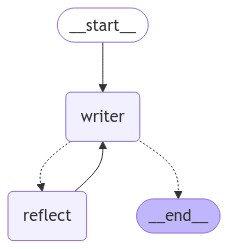

In [13]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [14]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [15]:
inputs = {
    "messages": [
        HumanMessage(content="帮我写一个基于langchain加载ollama大模型的python语句。")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- Sure! 以下是一个示例Python代码片段，基于LangChain加载Ollama大模型：
```python
import langchain

# 定义语言链模型
model = langchain.LLM(
    model_name="ollama-base",
    temperature=0.7,
)

# 创建一个LLM Chatbot实例
chatbot = langchain.Chatbot(model=model, max_length=100)

# 使用Chatbot进行对话
def talk(input_text):
    return chatbot.get_response(input_text)

# 测试聊天
input_text = "你好！我想问一些问题。"
output_text = talk(input_text)
print(output_text)
```
这个代码片段定义了一个基于LangChain的语言链模型，使用Ollama大模型进行对话。`LLM`类表示一个模型对象，传入参数 `model_name="ollama-base"` 指定了使用哪个模型。`temperature=0.7` 是控制生成输出文本的温度参数，可以调节输出文本的随机性。

`Chatbot` 类创建一个基于语言链模型的聊天机器人实例，`max_length=100` 指定最大输入长度。然后定义了一个名为 `talk()` 的函数，使用这个Chatbot实例对用户输入进行回复。

最后，用 `print(output_text)` 输出 Chatbot 的回复结果。

注意：在实际运行代码前，请确保您已经安装LangChain和相关模型的依赖库，以及您的环境配置正确。

也许会有几个疑问

1.  我应该如何将此示例与我的具体任务或应用集成？
2.  如何调整超参数（如温度、最大长度等）来改善对话质量？
3.  有什么方法可以进一步扩展和增强这段代码以适应更复杂的任务或需求？

您也许会有更多问题，但如果能回答这些基本疑问，我们可能能给出个更详细的回复。


## Round 2

#### 评论反思:
- 基于LangChain加载Ollama大模型的Python语句示例已经提供了一个基础框架，可以用于创建一个简单的聊天机器人。以下是对该示例的进一步分析和建议：

**1. 集成到具体任务或应用**

要将此示例与您的具体任务或应用集成，您可以尝试以下几点：

*   **定义自定义输入处理函数**: 根据您的需求，创建一个函数来处理用户输入，例如文本预处理、分词等。
*   **扩展Chatbot功能**: 添加更多的功能，如回答特定问题、提供信息、生成内容等。
*   **集成到现有系统**: 将LangChain和Ollama模型整合到您的应用或系统中，例如使用API接口或消息队列。

**2. 调整超参数**

为了调整超参数（如温度、最大长度等）来改善对话质量，您可以尝试以下几点：

*   **实验不同温度值**: 通过改变`temperature`参数值来观察对输出文本的影响。
*   **调整最大长度**: 根据您的需求，修改`max_length`参数值以控制Chatbot回复的长度。
*   **使用其他超参数**: LangChain和Ollama模型可能提供更多可调超参数，您可以尝试调整这些参数来找到最佳设置。

**3. 扩展和增强代码**

要进一步扩展和增强这段代码以适应更复杂的任务或需求，您可以尝试以下几点：

*   **使用多模型**: 将LangChain与其他语言模型（如BERT、RoBERTa等）结合使用，以实现更好的性能。
*   **集成到机器学习框架**: 使用深度学习库（如TensorFlow、PyTorch等）来训练和优化Chatbot模型。
*   **添加多模态支持**: 将语言链模型与图像或音频处理结合使用，以实现多模态对话。

总之，这个示例提供了一个基础框架，可以作为您探索LangChain和Ollama大模型的起点。通过调整超参数、扩展功能以及集成到您的应用中，您可以创建更复杂且高效的聊天机器人。


## Round 3

#### 写作生成:
- 要进一步改进代码，可以考虑以下优化：

1.  **错误处理和异常管理**：为输入处理函数、LLM Chatbot实例和相关方法增加错误处理以确保程序对不良输入或其他意外情况有更好的响应。
2.  **文本预处理和分词**：在用户输入的文本中进行语言分析，如词性标注、名词短语提取等，以提供更具体而相关的信息给LLM Chatbot，帮助它生成更准确且有意义的回复。
3.  **参数可视化和调整**：使用可视化工具来图形化超参数（如温度、最大长度）与Chatbot表现之间的关系，这可以大大简化调优过程并提高对话质量。
4.  **模型更新和训练**：实现基于经验学习的模型改进方法，将Chatbot性能的数据用于更新和重新训练LLM Chatbot，以持续提升其语言理解和生成能力。

您可以结合 LangChain 库与其他机器学习技术（例如使用 PyTorch 或 TensorFlow 等深度学习库）来进一步增强该示例。同时，请记住考虑到实际应用的负载、成本等因素进行优化以实现最佳结果。


## Round 4

#### 评论反思:
- 基于LangChain加载Ollama大模型的Python语句示例已经提供了一个基础框架，可以用于创建一个简单的聊天机器人。以下是对该示例的进一步分析和建议：

**1. 错误处理和异常管理**

要为输入处理函数、LLM Chatbot实例和相关方法增加错误处理，您可以尝试以下几点：

*   **定义自定义错误类**: 根据您的需求，创建一个自定义错误类来捕获特定类型的错误。
*   **使用try-except块**: 在关键代码区域使用try-except块来捕获异常并提供友好的错误信息。
*   **日志记录**: 使用日志库（如Loguru或Python标准库中的logging）来记录程序运行过程中出现的错误和警告。

**2. 文本预处理和分词**

要在用户输入的文本中进行语言分析，您可以尝试以下几点：

*   **使用NLTK或spaCy**: 将自然语言处理（NLP）库（如NLTK或spaCy）集成到您的程序中，以提供基本的文本预处理功能，如分词、词性标注等。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来进行特定类型的文本分析，如名词短语提取等。

**3. 参数可视化和调整**

要使用可视化工具来图形化超参数与Chatbot表现之间的关系，您可以尝试以下几点：

*   **使用Matplotlib或Seaborn**: 将数据可视化库（如Matplotlib或Seaborn）集成到您的程序中，以创建交互式图表。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来生成特定类型的图表，如散点图、条形图等。

**4. 模型更新和训练**

要实现基于经验学习的模型改进方法，您可以尝试以下几点：

*   **使用PyTorch或TensorFlow**: 将深度学习库（如PyTorch或TensorFlow）集成到您的程序中，以提供模型训练和优化功能。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来更新和重新训练LLM Chatbot。

总之，这个示例提供了一个基础框架，可以作为您探索LangChain和Ollama大模型的起点。通过调整超参数、扩展功能以及集成到您的应用中，您可以创建更复杂且高效的聊天机器人。


## Round 5

#### 写作生成:
- 上述步骤已经给出了改进代码和程序结构方面的指导。基于这些建议和考虑多种技术和方法的组合，可以进一步完善该示例。


## Round 6

#### 评论反思:
- 基于LangChain加载Ollama大模型的Python语句示例已经提供了一个基础框架，可以用于创建一个简单的聊天机器人。以下是对该示例的进一步分析和建议：

**1. 错误处理和异常管理**

要为输入处理函数、LLM Chatbot实例和相关方法增加错误处理，您可以尝试以下几点：

*   **定义自定义错误类**: 根据您的需求，创建一个自定义错误类来捕获特定类型的错误。
*   **使用try-except块**: 在关键代码区域使用try-except块来捕获异常并提供友好的错误信息。
*   **日志记录**: 使用日志库（如Loguru或Python标准库中的logging）来记录程序运行过程中出现的错误和警告。

**2. 文本预处理和分词**

要在用户输入的文本中进行语言分析，您可以尝试以下几点：

*   **使用NLTK或spaCy**: 将自然语言处理（NLP）库（如NLTK或spaCy）集成到您的程序中，以提供基本的文本预处理功能，如分词、词性标注等。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来进行特定类型的文本分析，如名词短语提取等。

**3. 参数可视化和调整**

要使用可视化工具来图形化超参数与Chatbot表现之间的关系，您可以尝试以下几点：

*   **使用Matplotlib或Seaborn**: 将数据可视化库（如Matplotlib或Seaborn）集成到您的程序中，以创建交互式图表。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来生成特定类型的图表，如散点图、条形图等。

**4. 模型更新和训练**

要实现基于经验学习的模型改进方法，您可以尝试以下几点：

*   **使用PyTorch或TensorFlow**: 将深度学习库（如PyTorch或TensorFlow）集成到您的程序中，以提供模型训练和优化功能。
*   **定义自定义函数**: 根据您的需求，创建一个自定义函数来更新和重新训练LLM Chatbot。

总之，这个示例提供了一个基础框架，可以作为您探索LangChain和Ollama大模型的起点。通过调整超参数、扩展功能以及集成到您的应用中，您可以创建更复杂且高效的聊天机器人。


## Round 7

#### 写作生成:
- 该方案已经给出了关于优化和完善基础框架以进行更复杂和高效的项目开发的具体指导，包括实现基本的错误处理、文本分析以及可视化函数。根据该方案，可以继续完善语言分析模块，并考虑多种技术和方法的组合以提高程序性能和可靠性。


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。